In [ ]:
!pip install datasets transformers scikit-learn matplotlib seaborn tqdm


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


Load Dataset - pietrolesci/pubmed-200k-rct

In [ ]:
dataset = load_dataset("pietrolesci/pubmed-200k-rct")

train_data = dataset["train"].shuffle(seed=42).select(range(5000))  # subset for speed
test_data = dataset["test"].shuffle(seed=42).select(range(1000))

train_df = pd.DataFrame(train_data)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-12ed98a863dcf4(…):   0%|          | 0.00/204M [00:00<?, ?B/s]

data/validation-00000-of-00001-6f6e21b16(…):   0%|          | 0.00/2.68M [00:00<?, ?B/s]

data/test-00000-of-00001-1d0cf0c8a9ba23d(…):   0%|          | 0.00/2.70M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2211861 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/28932 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29493 [00:00<?, ? examples/s]

In [ ]:
train_df.columns

Index(['labels', 'text', 'uid'], dtype='object')

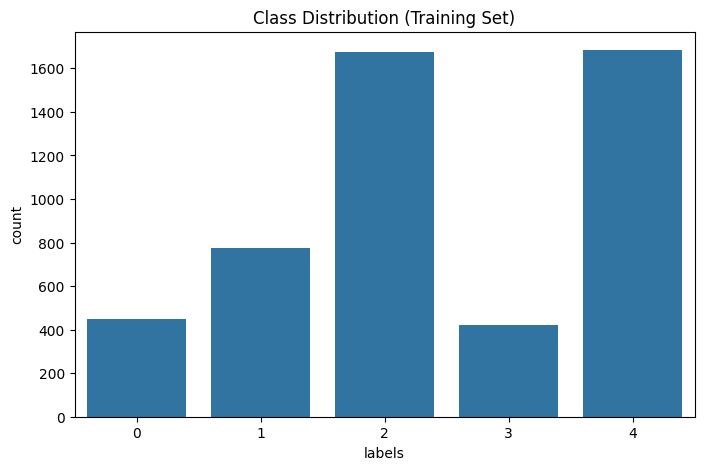

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x=train_df["labels"])
plt.title("Class Distribution (Training Set)")
plt.show()


In [ ]:
label_names = train_data.features["labels"].names
label2id = {label: i for i, label in enumerate(label_names)}
id2label = {i: label for label, i in label2id.items()}
label_names

['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']

The dataset shows moderate class imbalance, with METHODS and RESULTS having higher frequencies compared to OBJECTIVE and CONCLUSIONS. Weighted evaluation metrics are therefore appropriate.

TOKENIZER + DATASET CLASS

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 128

class PubMedDataset(Dataset):
    def __init__(self, data):
        self.texts = data["text"]
        self.labels = data["labels"]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_dataset = PubMedDataset(train_data)
test_dataset = PubMedDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return self.classifier(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_names)
model = BertClassifier(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
epochs = 2

for epoch in range(epochs):
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")


Epoch 1: 100%|██████████| 625/625 [02:30<00:00,  4.15it/s, loss=0.267]


Epoch 1 Loss: 0.6398


Epoch 2: 100%|██████████| 625/625 [02:31<00:00,  4.14it/s, loss=0.56]

Epoch 2 Loss: 0.3586


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


100%|██████████| 125/125 [00:07<00:00, 16.25it/s]


In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.844
Precision: 0.847473757655586
Recall: 0.844
F1-score: 0.8422880545931763


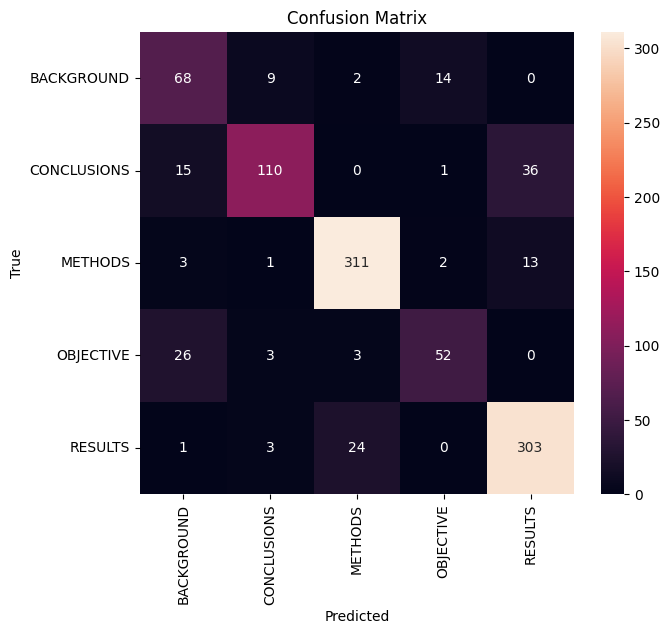

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Most misclassifications occur between semantically similar sections such as BACKGROUND vs OBJECTIVE and RESULTS vs CONCLUSIONS.


In [ ]:
def predict_text(text):
    model.eval()
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        confidence, pred = torch.max(probs, dim=1)

    return id2label[pred.item()], confidence.item()


In [ ]:
realistic_examples = [
    "Cardiovascular disease remains one of the leading causes of mortality worldwide.",

    "We investigated whether the new compound could reduce blood pressure in hypertensive patients.",

    "A total of 120 participants were enrolled and randomly divided into placebo and treatment groups.",

    "Participants receiving the treatment showed significantly lower cholesterol levels compared to controls.",

    "These findings support the use of the proposed intervention as a viable therapeutic option.",

    "Subjects received either the experimental drug or a placebo once daily for eight weeks.",

    "A marked improvement in lung function was observed among treated patients.",

    "Overall, the intervention demonstrates potential for clinical application."
]

for text in realistic_examples:
    label, conf = predict_text(text)
    print(f"Text: {text}")
    print(f"Prediction: {label}, Confidence: {conf:.4f}\n")

Text: Cardiovascular disease remains one of the leading causes of mortality worldwide.
Prediction: BACKGROUND, Confidence: 0.7465

Text: We investigated whether the new compound could reduce blood pressure in hypertensive patients.
Prediction: BACKGROUND, Confidence: 0.5006

Text: A total of 120 participants were enrolled and randomly divided into placebo and treatment groups.
Prediction: METHODS, Confidence: 0.9270

Text: Participants receiving the treatment showed significantly lower cholesterol levels compared to controls.
Prediction: RESULTS, Confidence: 0.9595

Text: These findings support the use of the proposed intervention as a viable therapeutic option.
Prediction: CONCLUSIONS, Confidence: 0.9413

Text: Cardiovascular disease remains one of the leading causes of mortality worldwide.
Prediction: BACKGROUND, Confidence: 0.7465

Text: Subjects received either the experimental drug or a placebo once daily for eight weeks.
Prediction: METHODS, Confidence: 0.9891

Text: A marked imp